In [1]:
import copy
import json, pickle
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit.primitives import BackendEstimator
from qiskit_ibm_runtime import Estimator as RuntimeEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima, FakeSherbrooke, FakeLimaV2, FakeWashington
from qiskit import QuantumCircuit, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister


from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from qiskit.quantum_info import Clifford
from qiskit_aer.noise import depolarizing_error, coherent_unitary_error, NoiseModel

from functools import partial

D = {'output': 'mpl', 'fold': -1, 'idle_wires': False}

In [2]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()

In [3]:
real_backend = provider.get_backend('ibm_brisbane')

In [4]:
from qiskit.circuit import Parameter

class IsingModel:

    class Options(dict):
        def __init__(self, *args, **kwargs):
            super().__init__()
            self['nq'] = 4
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4
            self['depth'] = 15
            self.update(*args, **kwargs)

        def config_4q_paper(self):
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_100q_paper_Clifford(self):
            self['nq'] = 100
            self['h'] = 0.5*np.pi
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_100q_paper_nonClifford(self):
            self['nq'] = 100
            self['h'] = 0.66*np.pi
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_6q_paper(self):
            self['nq'] = 6
            self['h'] = np.pi
            self['J'] = 0.15
            self['dt'] = 1/4*2

    @classmethod
    def apply_quantum_circuit_layer(cls, qc: QuantumCircuit, ops: 'IsingModel.Options'):
        allq = list(range(ops['nq']))

        qc.rx(2*ops['h']*ops['dt'], allq)

        qc.barrier()
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[1::2])
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)

        qc.barrier()
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[2:-1:2])
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.barrier()

    @classmethod
    def make_quantum_circuit(cls, ops: 'IsingModel.Options'):
        qc = QuantumCircuit(ops['nq'])
        allq = list(range(ops['nq']))

        for step in range(ops['depth']):
            cls.apply_quantum_circuit_layer(qc, ops)

        if ops['measure_basis'] == 'Z':
            pass
        elif  ops['measure_basis'] == 'X':
            qc.h(allq)
        elif  ops['measure_basis'] == 'Y':
            qc.sdg(allq)
            qc.h(allq)
        else:
            raise Exception("Must be X Y or Z")
        qc.measure_all()

        return qc

    @classmethod
    def make_circs_sweep(cls, ops, num_steps, measure_basis):
        ops['measure_basis'] = measure_basis
        ops['depth'] = num_steps
        qc = cls.make_quantum_circuit(ops)
        qc.metadata = {}
        qc.metadata['measure_basis'] = measure_basis
        qc.metadata['depth'] = num_steps
        return qc

In [5]:
brisbane_layout = list(range(113, 127)) + [112] + list(range(108, 93, -1)) + [90] + list(range(75, 90)) + [74] + list(range(70, 55, -1)) + [52] + list(range(37, 44)) + [34] + list(range(24, 17, -1)) + [14] + list(range(0, 13)) + [17, 30, 31, 32, 36, 51, 50, 49]

print(len(brisbane_layout))

100


In [6]:
from qiskit.transpiler.passes import RemoveBarriers
def construct_ising_circuit_100q_Clifford(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_100q_paper_Clifford()
    ops.update({'J': J})
    qc = cls.make_circs_sweep(ops, num_steps, basis)
    return qc

def construct_ising_circuit_100q_nonClifford(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_100q_paper_nonClifford()
    ops.update({'J': J})
    qc = cls.make_circs_sweep(ops, num_steps, basis)
    return qc

In [7]:
def form_all_qubit_observable(observable, measurement_qubits, total_num_qubits):
    """Input observable in non-endian, output observable in endian"""
    assert len(observable) == len(measurement_qubits)
    converted_obs = list('I' * total_num_qubits)
    for qubit, basis in zip(measurement_qubits, list(observable)):
        converted_obs[qubit] = basis
    return ''.join(converted_obs)[::-1]

def get_measurement_qubits(qc, num_measured_qubit):
    measurement_qubits = []
    for measurement in range(num_measured_qubit - 1, -1, -1):
        measurement_qubits.append(qc.data[-1 - measurement][1][0].index)
    return measurement_qubits

def get_Js(num_Js, num_q):
    np.random.seed(42)
    if num_q == 100:
        h = np.pi * 0.66
    else:
        raise NotImplementedError
    return np.random.uniform(0, h, size=num_Js)

from pec_runtime.utils.stratify import stratify_circuit_into_layers
from pec_runtime.circuit import TwirledCircuit

def construct_random_ising_sameJ_twirled_nonCliff_func(J, be, num_q, num_steps, num_twirl=2):
    basis = 'Z'
    if num_q == 100:
        random_ising = construct_ising_circuit_100q_nonClifford(J, basis, num_steps)
    else:
        raise NotImplementedError

    random_ising.remove_final_measurements()
    layers = stratify_circuit_into_layers(random_ising, twirled_qubits=list(range(num_q)))
    twirled_body = TwirledCircuit(layers, barriers=True)
    random_ising_list = twirled_body.sample_circuits(num_samples=num_twirl)

    ranges_to_remove = [(i, i+6) for i in range(1, 100, 8)]
    random_ising_list_opt = []
    for circuit in random_ising_list:
        new_circuit = QuantumCircuit(*circuit.qregs)
        barrier_count = 0
        for op, qubits, _ in circuit.data:
            if op.name == 'barrier':
                barrier_count += 1
                if any(start <= barrier_count <= end for start, end in ranges_to_remove):
                    continue
            new_circuit.append(op, qubits)
        random_ising_list_opt.append(new_circuit)

    for i in range(len(random_ising_list_opt)):
        random_ising_list_opt[i].measure_all()

    trans_circuits = transpile(
        random_ising_list_opt,
        backend=be,
        optimization_level=3,
        initial_layout=brisbane_layout,
    )
    return trans_circuits, J

def construct_random_ising_sameJ_twirled_Cliff_func(be, num_q, num_steps, num_twirl=2):
    basis = 'Z'
    if num_q == 100:
        random_ising = construct_ising_circuit_100q_Clifford(0, basis, num_steps)
    else:
        raise NotImplementedError

    random_ising.remove_final_measurements()
    layers = stratify_circuit_into_layers(random_ising, twirled_qubits=list(range(num_q)))
    twirled_body = TwirledCircuit(layers, barriers=True)
    random_ising_list = twirled_body.sample_circuits(num_samples=num_twirl)

    ranges_to_remove = [(i, i+6) for i in range(1, 100, 8)]
    random_ising_list_opt = []
    for circuit in random_ising_list:
        new_circuit = QuantumCircuit(*circuit.qregs)
        barrier_count = 0
        for op, qubits, _ in circuit.data:
            if op.name == 'barrier':
                barrier_count += 1
                if any(start <= barrier_count <= end for start, end in ranges_to_remove):
                    continue
            new_circuit.append(op, qubits)
        random_ising_list_opt.append(new_circuit)

    for i in range(len(random_ising_list_opt)):
        random_ising_list_opt[i].measure_all()

    trans_circuits = transpile(
        random_ising_list_opt,
        backend=be,
        optimization_level=3,
        initial_layout=brisbane_layout,
    )
    return trans_circuits, J

In [ ]:
with open('./data/ising_zne_hardware/98q_sherbrooke_sameJ_h0.66pi/step_01.pk', 'rb') as file:
    loaded = pickle.load(file)

circ = loaded[1]['circuit']
circ.remove_final_measurements()
circ.draw(**D)

# Check generated circuits

In [15]:
import os
from tqdm.notebook import tqdm
def load_circuits(data_dir, filename, f_ext='.pk'):
    circuits_twirled = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    J = []
    data_files = sorted([os.path.join(data_dir, f) for f in [filename]])
    for data_file in data_files:
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits_twirled.append(entry['circuit_twirled'])
                J.append(entry['J'])
    return circuits_twirled, J

circuits_twirled, J = load_circuits('./data/optional_ising_zne_hardware_twirled/100q_brisbane/circuits', 'step_05_J00.pk')

In [7]:
circuits_twirled

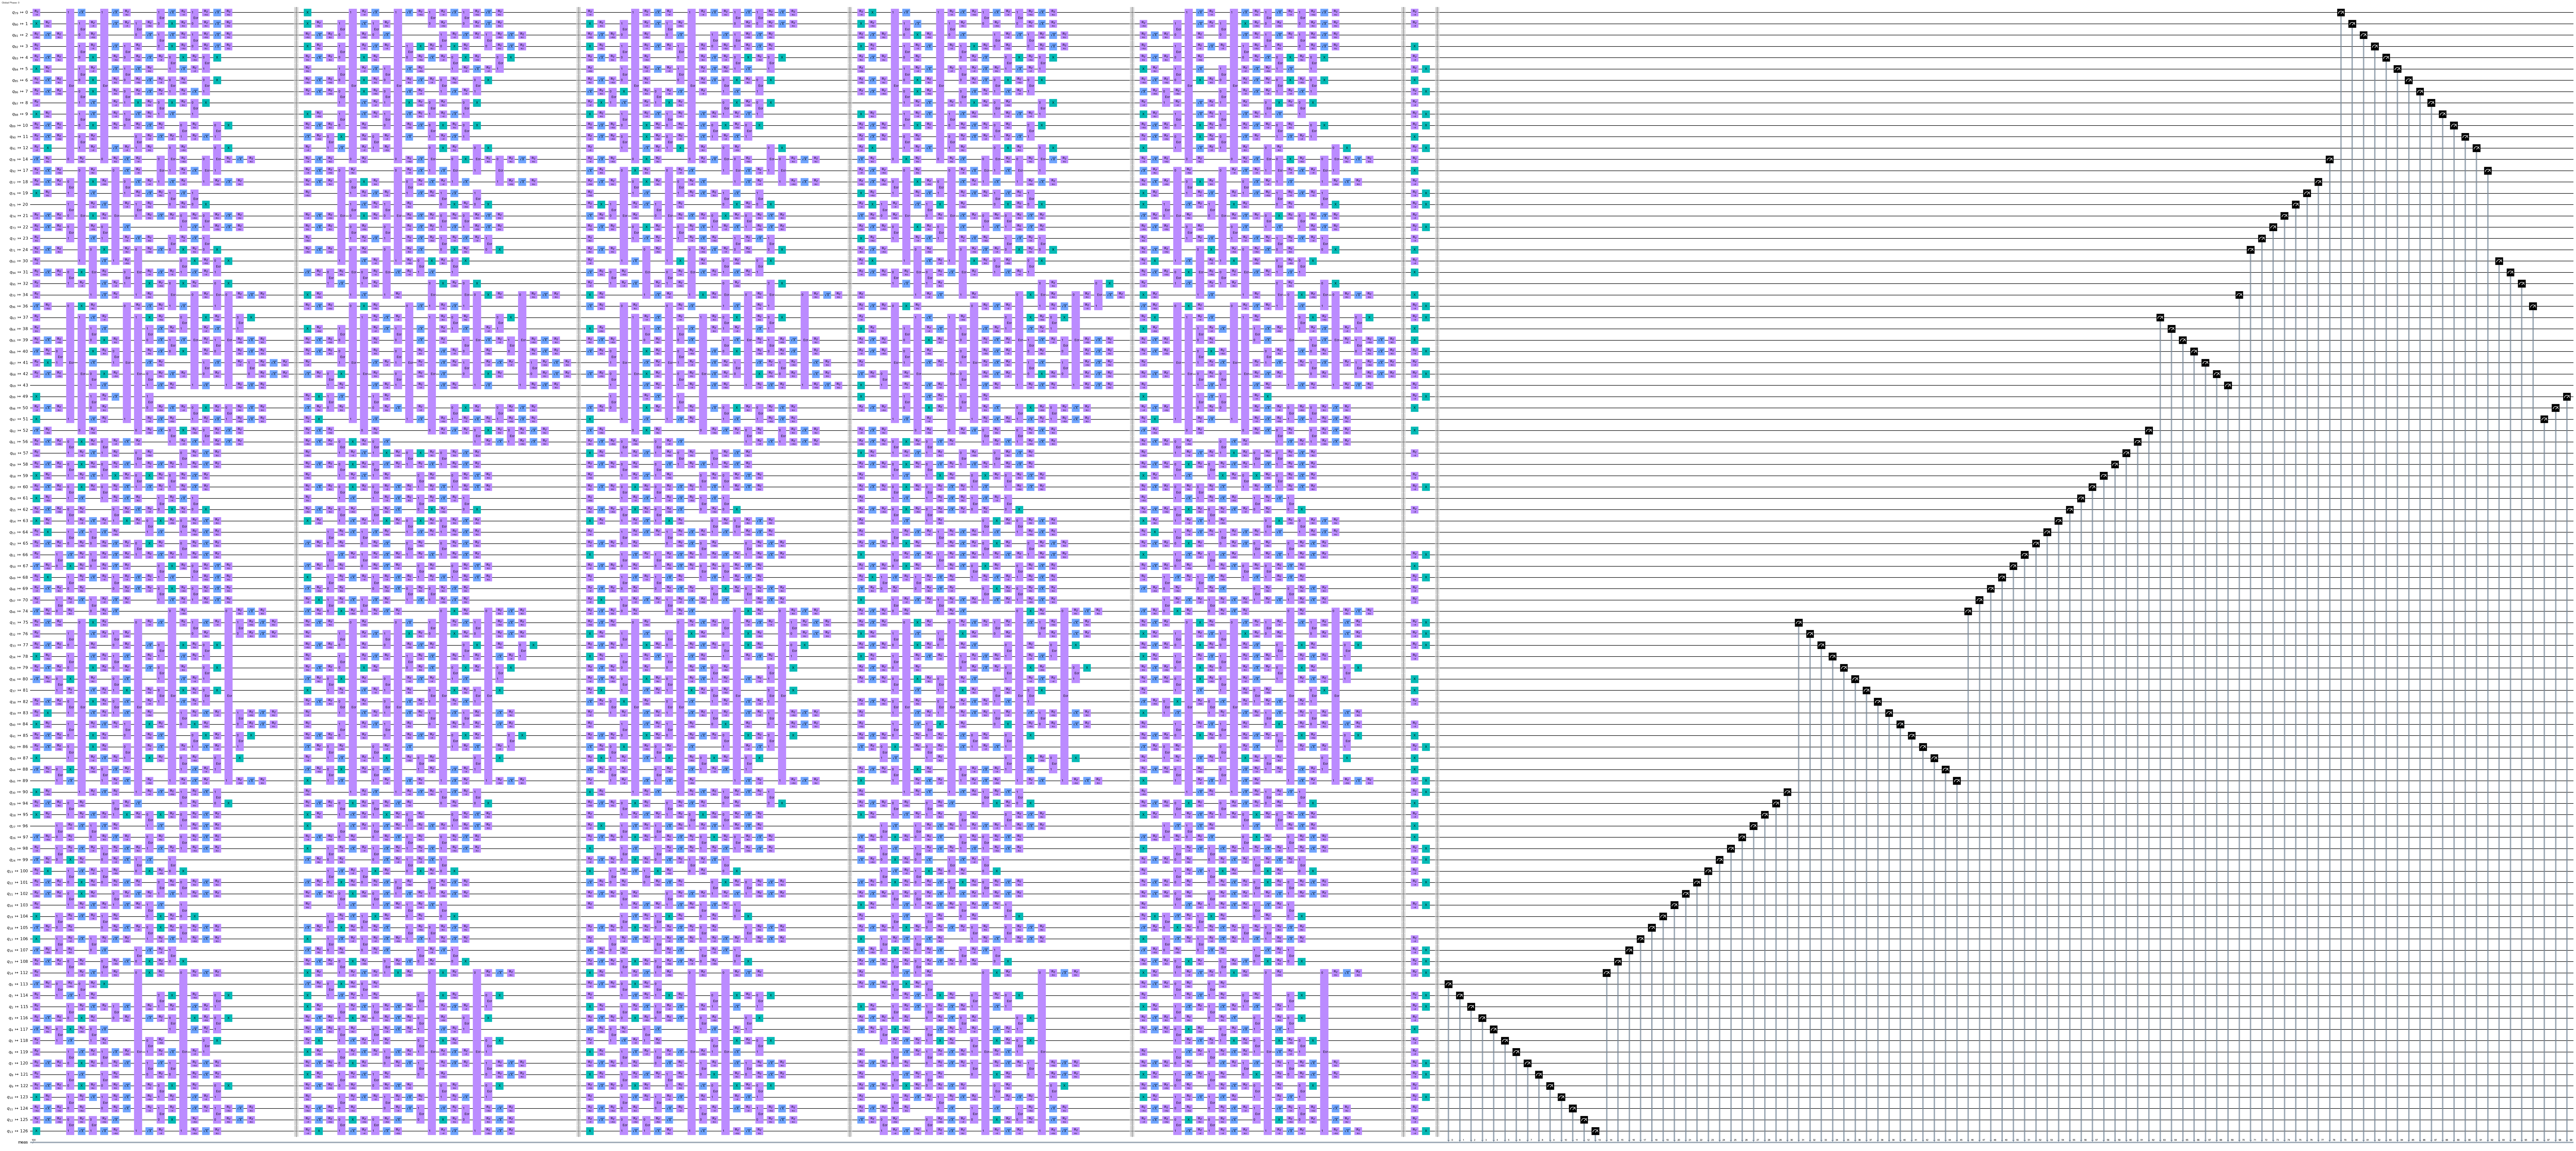

In [8]:
# train_circuits[61].remove_final_measurements()
circuits_twirled[0].draw(**D)

# Select Observables

In [26]:
circuits_twirled, J = load_circuits('./data/optional_ising_zne_hardware_twirled/100q_brisbane/circuits', 'step_01_J00.pk')

obs_list = ['I'*5+'Z'+'I'*94, 'I'*44+'Z'+'I'*55, 'I'*62+'Z'+'I'*37, 'I'*75+'Z'+'I'*24, 'I'*89+'Z'+'I'*10]
padded_obs_all_circs = []
for trans_circuit in circuits_twirled:
    padded_obs_all_circs += [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 100), 127)) for obs in obs_list]

In [27]:
print([126-padded_obs_all_circs[i].paulis.to_labels()[0].find('Z') for i in range(5)])

[118, 88, 52, 20, 10]


# Submission

In [28]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options
options = Options()
options.resilience_level = 2
options.optimization_level = 0
options.execution.shots = 10000
options.resilience.noise_factors = (1, 1.2, 1.6)
options.resilience.noise_amplifier = 'TwoQubitAmplifier'
options.resilience.extrapolator = 'LinearExtrapolator'
service = QiskitRuntimeService()

In [29]:
runtime_estimator = RuntimeEstimator(session=Session(service=service, backend="ibm_brisbane"), options=options)

In [30]:
num_twirls = 5
obs_list = ['I'*5+'Z'+'I'*94,
            'I'*44+'Z'+'I'*55,
            'I'*62+'Z'+'I'*37,
            'I'*75+'Z'+'I'*24,
            'I'*89+'Z'+'I'*10]

J_index = 0
for step_index in range(18):
    circuits_twirled, J = load_circuits(
        './data/optional_ising_zne_hardware_twirled/100q_brisbane/circuits',
        'step_%02d_J%02d.pk'%(step_index, J_index)
    )
    assert len(circuits_twirled) == num_twirls
    padded_obs_all_circs = []
    for trans_circuit in circuits_twirled:
        padded_obs_all_circs += [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 100), 127)) for obs in obs_list]

    circs_to_submit = []
    for circ in circuits_twirled:
        circ.remove_final_measurements()
        circs_to_submit.extend([circ]*len(obs_list))

    job = runtime_estimator.run(
        circuits=circs_to_submit,
        observables=padded_obs_all_circs
    )

    to_save = dict()
    to_save['job_id'] = job.job_id()
    to_save['J_index'] = J_index
    to_save['step_index'] = step_index
    to_save['measured_qubits'] = [118, 88, 52, 20, 10]
    print(J_index, job.job_id(), len(circs_to_submit))

    with open('./data/optional_ising_zne_hardware_twirled/100q_brisbane/job_ids/step_%02d_J%02d.json'%(step_index, J_index), 'w') as file:
        json.dump(to_save, file)

0 cifedqf985671v3veopg 25
0 cifedqmp0prapsg5mk30 25
0 cifedr460l54kv9nrk90 25
0 cifedrm4c9s1cd6q1l2g 25
0 cifedsmp0prapsg5mnm0 25
0 cifedte4c9s1cd6q1o50 25
0 cifedun985671v3vf0lg 25
0 cifedvru5mrpmcc923og 25
0 cifee0ru5mrpmcc925dg 25
0 cifee1r5n9v6ta7ghg40 25
0 cifee3b5n9v6ta7ghj2g 25
0 cifee4n985671v3vfc20 25
0 cifee635n9v6ta7ghm80 25
0 cifee8460l54kv9nscg0 25
0 cifee9v985671v3vfl9g 25
0 cifeebs60l54kv9nsjj0 25
0 cifeee35n9v6ta7gi560 25
0 cifeegc60l54kv9nsrsg 25


In [26]:
circuit = circs_to_submit[0]
circuit.remove_final_measurements()

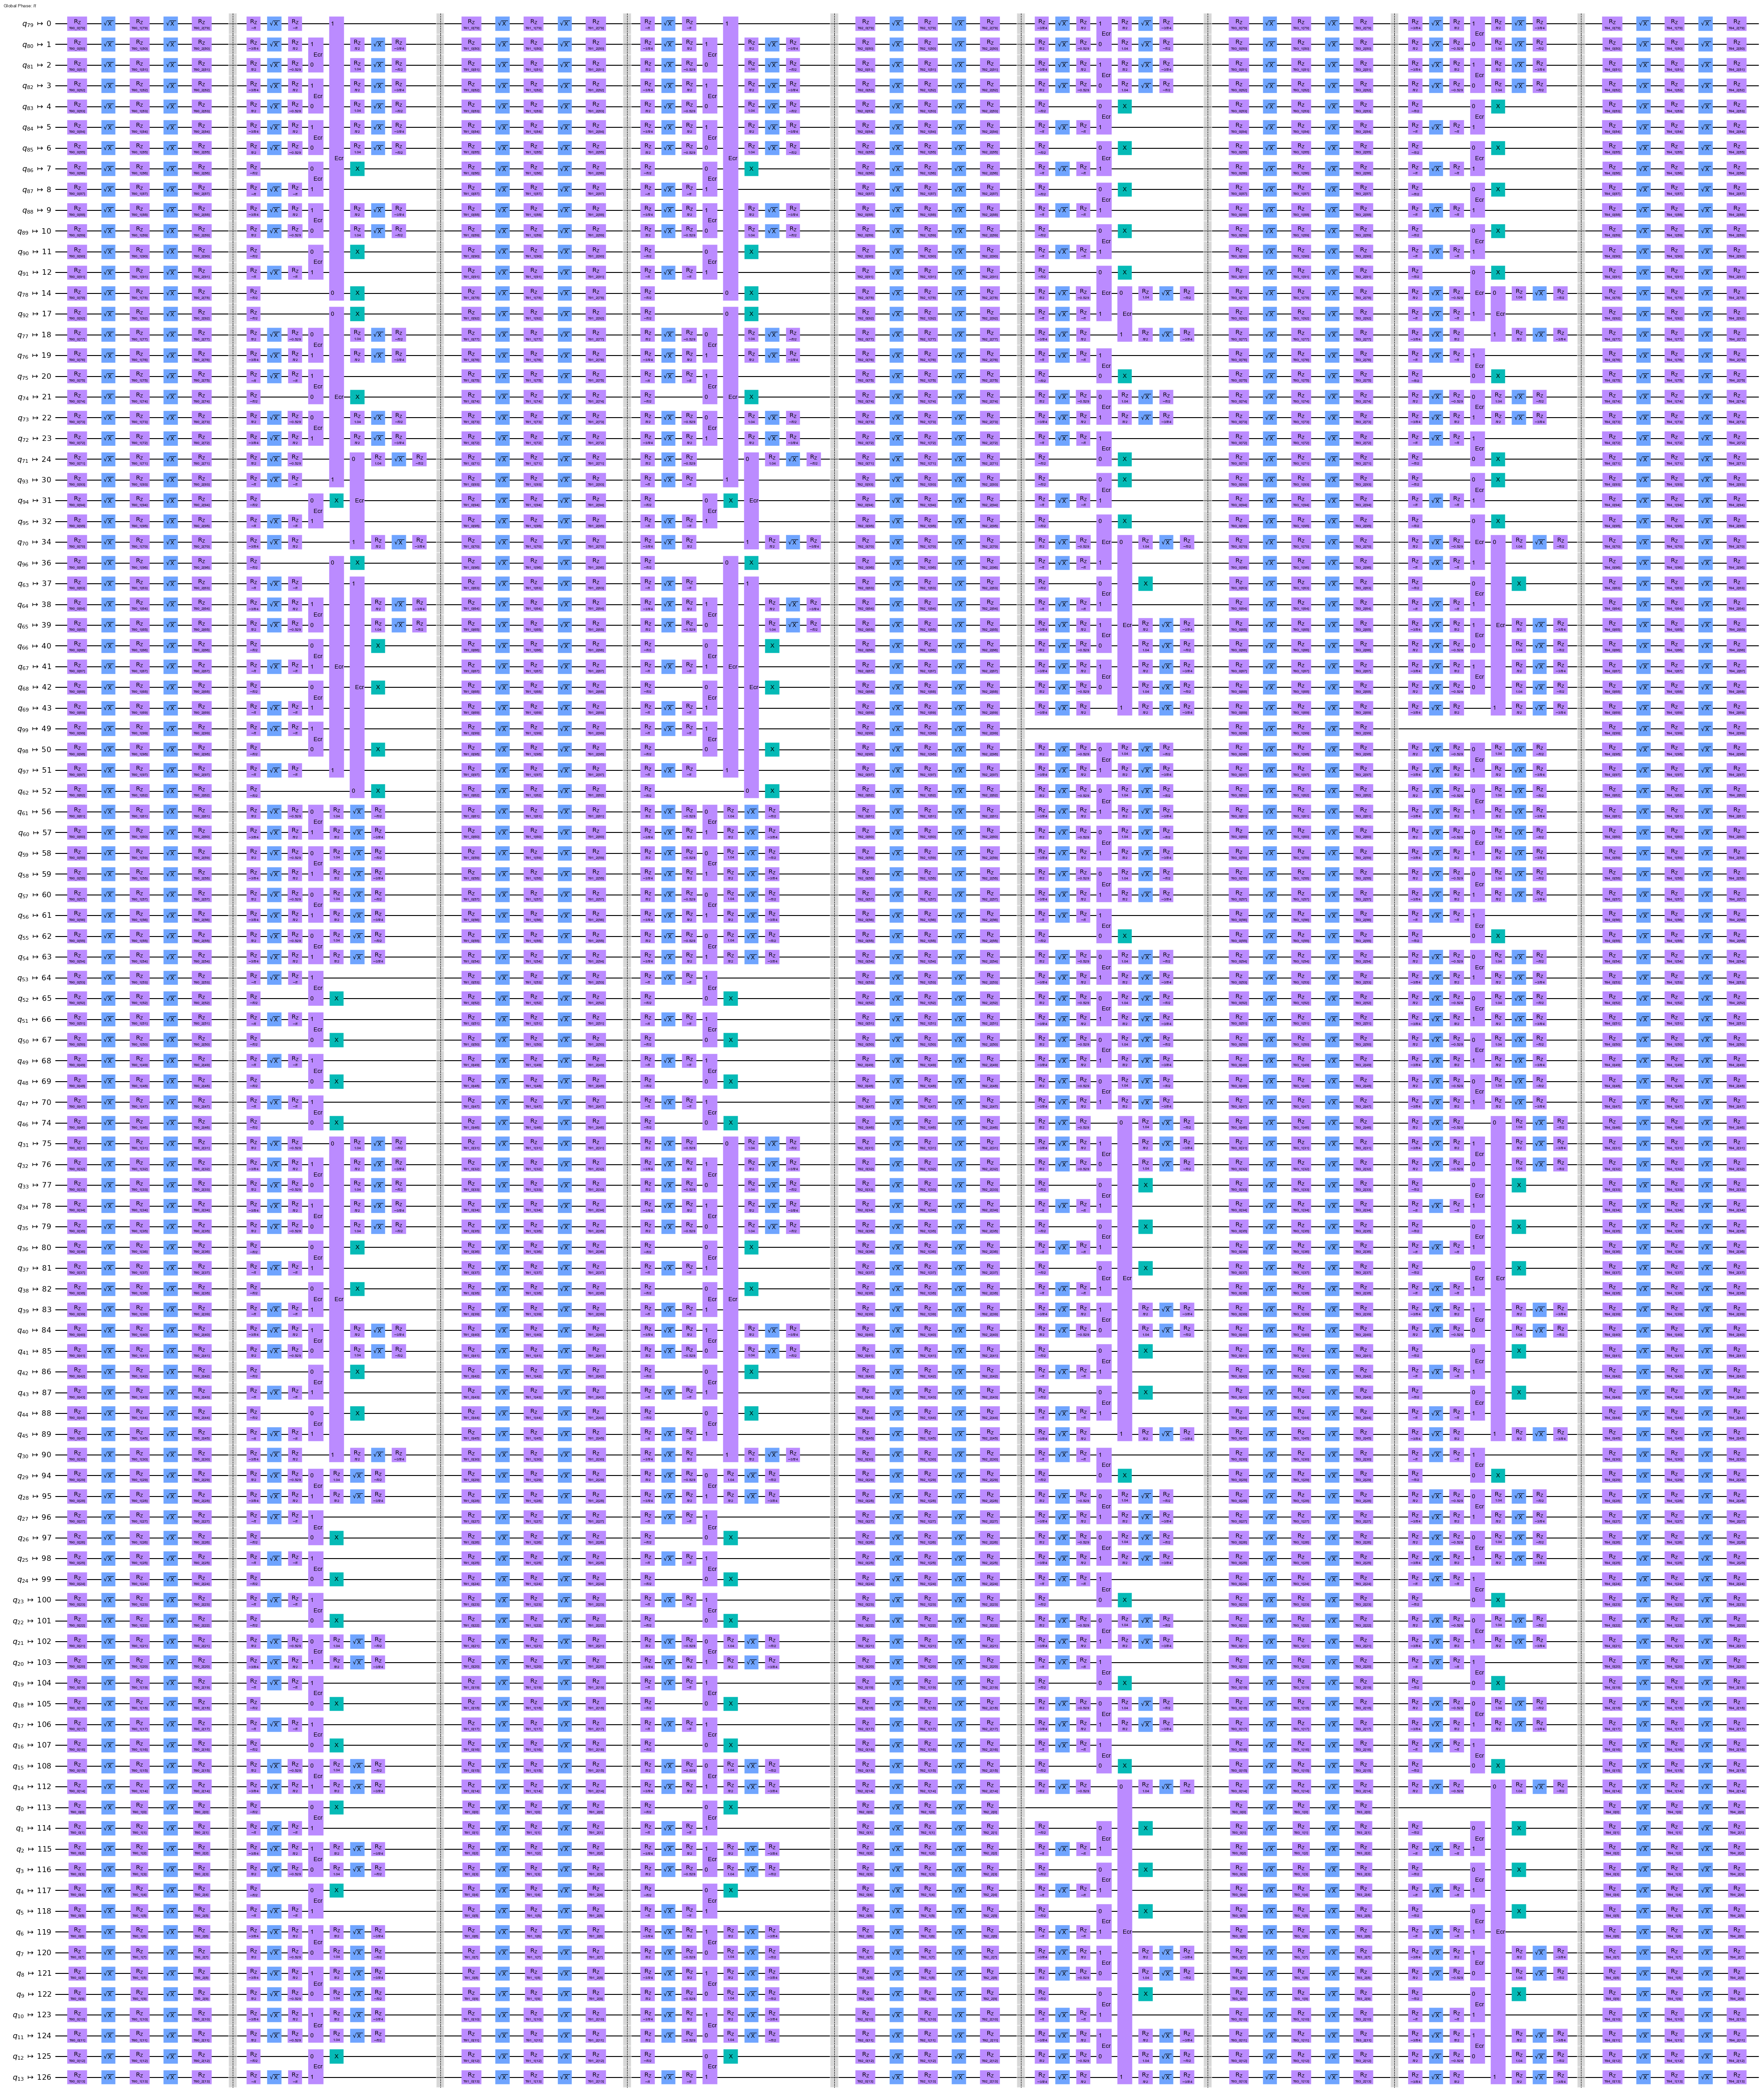

In [27]:
circuit.draw(**D)

# Resubmission

In [10]:
import os
from tqdm.notebook import tqdm

def check_f(f, f_ext, step_indices):
    return f.endswith(f_ext) and any([f"step_%02d"%step_index in f for step_index in step_indices])

def check_status(data_dir, step_indices, f_ext='.json'):
    callback = []
    data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if check_f(f, f_ext, step_indices)])
    for data_file in tqdm(data_files, leave=True):
        loaded = json.load(open(data_file, 'r'))
        job_status = service.job(loaded['job_id']).status()
        step_index = loaded['step_index']
        J_index = loaded['J_index']
        print(step_index, J_index, job_status)
        if job_status.name == 'ERROR':
            callback.append([step_index, J_index, job_status])
    print('-'*50)
    for x, y, z in callback: print(x, y, z)

check_status('./data/optional_ising_zne_hardware_twirled/100q_brisbane/job_ids/', list(range(17)))

  0%|          | 0/17 [00:00<?, ?it/s]

0 0 JobStatus.DONE
1 0 JobStatus.DONE
2 0 JobStatus.DONE
3 0 JobStatus.DONE
4 0 JobStatus.DONE
5 0 JobStatus.DONE
6 0 JobStatus.DONE
7 0 JobStatus.DONE
8 0 JobStatus.DONE
9 0 JobStatus.DONE
10 0 JobStatus.DONE
11 0 JobStatus.DONE
12 0 JobStatus.DONE
13 0 JobStatus.DONE
14 0 JobStatus.DONE
15 0 JobStatus.ERROR
16 0 JobStatus.DONE
--------------------------------------------------
15 0 JobStatus.ERROR


In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options
options = Options()
options.resilience_level = 2
options.optimization_level = 0
options.execution.shots = 10000
options.resilience.noise_factors = (1, 1.2, 1.6)
options.resilience.noise_amplifier = 'TwoQubitAmplifier'
options.resilience.extrapolator = 'LinearExtrapolator'
service = QiskitRuntimeService()

In [13]:
runtime_estimator = RuntimeEstimator(session=Session(service=service, backend="ibm_brisbane"), options=options)

In [17]:
num_twirls = 5
obs_list = ['I'*5+'Z'+'I'*94,
            'I'*44+'Z'+'I'*55,
            'I'*62+'Z'+'I'*37,
            'I'*75+'Z'+'I'*24,
            'I'*89+'Z'+'I'*10]

step_index = 15
for J_index in [0]:
    circuits_twirled, J = load_circuits(
        './data/optional_ising_zne_hardware_twirled/100q_brisbane/circuits',
        'step_%02d_J%02d.pk'%(step_index, J_index)
    )
    assert len(circuits_twirled) == num_twirls
    padded_obs_all_circs = []
    for trans_circuit in circuits_twirled:
        padded_obs_all_circs += [SparsePauliOp(form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 100), 127)) for obs in obs_list]

    circs_to_submit = []
    for circ in circuits_twirled:
        circ.remove_final_measurements()
        circs_to_submit.extend([circ]*len(obs_list))

    job = runtime_estimator.run(
        circuits=circs_to_submit,
        observables=padded_obs_all_circs
    )

    to_save = dict()
    to_save['job_id'] = job.job_id()
    to_save['J_index'] = J_index
    to_save['step_index'] = step_index
    to_save['measured_qubits'] = [118, 88, 52, 20, 10]
    print(J_index, job.job_id(), len(circs_to_submit))

    with open('./data/optional_ising_zne_hardware_twirled/100q_brisbane/job_ids/step_%02d_J%02d.json'%(step_index, J_index), 'w') as file:
        json.dump(to_save, file)

0 cifp4k460l54kva25b6g 25
